<a href="https://colab.research.google.com/github/EliasSf73/test_/blob/master/VAE_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

In [ ]:
!wget https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0

--2024-05-20 09:40:07--  https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/d1kjpkqklf0uw77/celeba.zip [following]
--2024-05-20 09:40:07--  https://www.dropbox.com/s/raw/d1kjpkqklf0uw77/celeba.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f9bf1b26fb7cef22682ff7e73.dl.dropboxusercontent.com/cd/0/inline/CTOwAaLYGRZcRZOxnWsJFDAceeUbbV2hsCuOPAF1fUzQ7ubl-LaNBPPjJ2OXCM2HlCSP3PUXUPJ6I_pcPaLSsBuNg4D_2qMpRF2jrI6p4YfZRiBE9vQH9cAY7aheQa7KjDUehF1evZCNg2TfQDpJoeR5/file# [following]
--2024-05-20 09:40:08--  https://uc7f9bf1b26fb7cef22682ff7e73.dl.dropboxusercontent.com/cd/0/inline/CTOwAaLYGRZcRZOxnWsJFDAceeUbbV2hsCuOPAF1fUzQ7ubl-LaNBPPjJ2OXCM2HlCSP3PUXUPJ6I_pcPaLSsBuNg4D_2qMpRF2jrI6

In [ ]:
!ls


'celeba.zip?dl=0'  'celeba.zip?dl=0.1'	 sample_data


In [ ]:
!unzip celeba.zip?dl=0

Streaming output truncated to the last 5000 lines.
  inflating: celeba/images/012465.jpg  
  inflating: celeba/images/089057.jpg  
  inflating: celeba/images/147796.jpg  
  inflating: celeba/images/192463.jpg  
  inflating: celeba/images/142818.jpg  
  inflating: celeba/images/148061.jpg  
  inflating: celeba/images/184432.jpg  
  inflating: celeba/images/201157.jpg  
  inflating: celeba/images/097288.jpg  
  inflating: celeba/images/130371.jpg  
  inflating: celeba/images/082864.jpg  
  inflating: celeba/images/017429.jpg  
  inflating: celeba/images/186077.jpg  
  inflating: celeba/images/126843.jpg  
  inflating: celeba/images/200381.jpg  
  inflating: celeba/images/012555.jpg  
  inflating: celeba/images/092238.jpg  
  inflating: celeba/images/008151.jpg  
  inflating: celeba/images/171418.jpg  
  inflating: celeba/images/155589.jpg  
  inflating: celeba/images/032110.jpg  
  inflating: celeba/images/098319.jpg  
  inflating: celeba/images/011702.jpg  
  inflating: celeba/images/17

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# from torchvision.datasets import CelebA
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Assume CelebA images are preprocessed to 64x64 pixels
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)  # 32x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 16x16
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 8x8
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 4x4
        self.flatten = nn.Flatten()  # Flatten the convolutional layer output
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)  # Fully connected layer for mean
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  # Fully connected layer for std

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.conv_trans1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans3 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.conv_trans4 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 4, 4)  # Reshape z to the initial size before the convolutional layers
        z = F.relu(self.conv_trans1(z))
        z = F.relu(self.conv_trans2(z))
        z = F.relu(self.conv_trans3(z))
        z = torch.sigmoid(self.conv_trans4(z))  # Output layer with sigmoid activation
        return z
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super(VAE,self).__init__()
        self.encoder=Encoder(latent_dim)
        self.decoder=Decoder(latent_dim)
    def reparametrize(self,mu,logvar):
        """
        Applies the reparameterization trick: z = mu + sigma * epsilon,
        where epsilon is sampled from a standard normal distribution.
        """
        std = torch.exp(0.5 * logvar)  # sigma = exp(0.5 * log_var), for numerical stability


        epsilon = torch.randn_like(std)  # Sample epsilon from a standard normal distribution
        z = mu + std * epsilon  # Reparameterize to get z
        return z
    def forward(self, x):
        """
        Defines the forward pass of the VAE.
        """
        mu, log_var = self.encoder(x)  # Encode input to get mu and log_var
        z = self.reparametrize(mu, log_var)  # Reparameterize to get latent vector z
        return self.decoder(z), mu, log_var


# Newest Train

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
# from models import VAE
from sklearn.model_selection import train_test_split

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
epochs = 10
latent_dim = 64
learning_rate = 1e-3
lambda_ = 1

# Adding Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Download the CelebA dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(), AddGaussianNoise(0.0, 0.1),        # Convert images to PyTorch tensors and add Gaussian noise
])

# celeba_dataset = datasets.CelebA(root='/content/celeba', split='train', download=False, transform=transform)
celeba_dataset = datasets.ImageFolder('/content/celeba', transform=transform)

# Split dataset into training and test sets
train_idx, test_idx = train_test_split(list(range(len(celeba_dataset))), test_size=0.2, random_state=42)
train_subset = Subset(celeba_dataset, train_idx)
test_subset = Subset(celeba_dataset, test_idx)

# Create DataLoaders for training and test sets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Initialize VAE model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to track losses
recon_losses = []
kl_losses = []
test_recon_losses = []
test_kl_losses = []

# Training function
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(data)
        recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * lambda_ / batch_size)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_recon_loss = train_loss / len(train_loader.dataset)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(kl_loss.item() / len(train_loader.dataset))
    print(f'====> Epoch: {epoch} Average loss: {avg_recon_loss:.4f}')

# Test function to evaluate on test set
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstruction, mu, log_var = model(data)
            recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + (kl_loss * lambda_ / batch_size)
            test_loss += loss.item()
    avg_test_recon_loss = test_loss / len(test_loader.dataset)
    test_recon_losses.append(avg_test_recon_loss)
    test_kl_losses.append(kl_loss.item() / len(test_loader.dataset))
    print(f'====> Test set loss: {avg_test_recon_loss:.4f}')

# Plotting the losses after training
def visualize_training_loss():
    plt.figure(figsize=(10,5))
    plt.title("Training and Test Losses")
    plt.plot(recon_losses, label="Train Reconstruction Loss")
    plt.plot(test_recon_losses, label="Test Reconstruction Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Function to visualize reconstructions
def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        reconstruction, _, _ = model(data)
        data = data.cpu()
        reconstruction = reconstruction.cpu()

        # Display original and reconstructed images
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
        for i in range(num_images):
            axs[0, i].imshow(np.transpose(data[i].numpy(), (1, 2, 0)))
            axs[0, i].set_title('Original')
            axs[1, i].imshow(np.transpose(reconstruction[i].numpy(), (1, 2, 0)))
            axs[1, i].set_title('Reconstruction')
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

# Training loop
for epoch in range(1, epochs + 1):
    train(epoch)
    test()  # Evaluate on test set after each epoch

# Save the model
torch.save(model.state_dict(), 'vae_model.pth')

# Visualize the training and test losses
visualize_training_loss()

# Visualize the reconstructions
visualize_reconstructions()

# Compare with non-Gaussian added version
# Download the CelebA dataset without Gaussian noise
transform_no_noise = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])
celeba_dataset_no_noise = datasets.ImageFolder('/content/celeba', transform=transform_no_noise)

# Split dataset into training and test sets
train_subset_no_noise = Subset(celeba_dataset_no_noise, train_idx)
test_subset_no_noise = Subset(celeba_dataset_no_noise, test_idx)

# Create DataLoaders for training and test sets
train_loader_no_noise = DataLoader(train_subset_no_noise, batch_size=batch_size, shuffle=True)
test_loader_no_noise = DataLoader(test_subset_no_noise, batch_size=batch_size, shuffle=False)

# Initialize VAE model and optimizer for no noise version
model_no_noise = VAE(latent_dim=latent_dim).to(device)
optimizer_no_noise = optim.Adam(model_no_noise.parameters(), lr=learning_rate)

# Lists to track losses for no noise version
recon_losses_no_noise = []
kl_losses_no_noise = []
test_recon_losses_no_noise = []
test_kl_losses_no_noise = []

# Training function for no noise version
def train_no_noise(epoch):
    model_no_noise.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_no_noise):
        data = data.to(device)
        optimizer_no_noise.zero_grad()
        reconstruction, mu, log_var = model_no_noise(data)
        recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * lambda_ / batch_size)
        loss.backward()
        train_loss += loss.item()
        optimizer_no_noise.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch (No Noise): {epoch} [{batch_idx * len(data)}/{len(train_loader_no_noise.dataset)} '
                  f'({100. * batch_idx / len(train_loader_no_noise):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_recon_loss = train_loss / len(train_loader_no_noise.dataset)
    recon_losses_no_noise.append(avg_recon_loss)
    kl_losses_no_noise.append(kl_loss.item() / len(train_loader_no_noise.dataset))
    print(f'====> Epoch (No Noise): {epoch} Average loss: {avg_recon_loss:.4f}')

# Test function to evaluate on test set for no noise version
def test_no_noise():
    model_no_noise.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader_no_noise:
            data = data.to(device)
            reconstruction, mu, log_var = model_no_noise(data)
            recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + (kl_loss * lambda_ / batch_size)
            test_loss += loss.item()
    avg_test_recon_loss = test_loss / len(test_loader_no_noise.dataset)
    test_recon_losses_no_noise.append(avg_test_recon_loss)
    test_kl_losses_no_noise.append(kl_loss.item() / len(test_loader_no_noise.dataset))
    print(f'====> Test set loss (No Noise): {avg_test_recon_loss:.4f}')

# Training loop for no noise version
for epoch in range(1, epochs + 1):
    train_no_noise(epoch)
    test_no_noise()  # Evaluate on test set after each epoch

# Visualize the training and test losses for no noise version
def visualize_training_loss_no_noise():
    plt.figure(figsize=(10,5))
    plt.title("Training and Test Losses (No Noise)")
    plt.plot(recon_losses_no_noise, label="Train Reconstruction Loss (No Noise)")
    plt.plot(test_recon_losses_no_noise, label="Test Reconstruction Loss (No Noise)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Visualize the reconstructions for no noise version
def visualize_reconstructions_no_noise():
    model_no_noise.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader_no_noise))
        data = data.to(device)
        reconstruction, _, _ = model_no_noise(data)
        data = data.cpu()
        reconstruction = reconstruction.cpu()

        # Display original and reconstructed images
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
        for i in range(num_images):
            axs[0, i].imshow(np.transpose(data[i].numpy(), (1, 2, 0)))
            axs[0, i].set_title('Original (No Noise)')
            axs[1, i].imshow(np.transpose(reconstruction[i].numpy(), (1, 2, 0)))
            axs[1, i].set_title('Reconstruction (No Noise)')
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

# Visualize the training and test losses for no noise version
visualize_training_loss_no_noise()

# Visualize the reconstructions for no noise version
visualize_reconstructions_no_noise()


Train Epoch: 1 [0/162079 (0%)]	Loss: 1140.130737
Train Epoch: 1 [6400/162079 (4%)]	Loss: 644.536316
Train Epoch: 1 [12800/162079 (8%)]	Loss: 391.291626
Train Epoch: 1 [19200/162079 (12%)]	Loss: 386.875427
Train Epoch: 1 [25600/162079 (16%)]	Loss: 346.506500
Train Epoch: 1 [32000/162079 (20%)]	Loss: 329.959473
Train Epoch: 1 [38400/162079 (24%)]	Loss: 315.260742
Train Epoch: 1 [44800/162079 (28%)]	Loss: 327.994507
Train Epoch: 1 [51200/162079 (32%)]	Loss: 279.242126
Train Epoch: 1 [57600/162079 (36%)]	Loss: 271.856171
Train Epoch: 1 [64000/162079 (39%)]	Loss: 275.413239
Train Epoch: 1 [70400/162079 (43%)]	Loss: 271.872772
Train Epoch: 1 [76800/162079 (47%)]	Loss: 252.461716
Train Epoch: 1 [83200/162079 (51%)]	Loss: 246.307938
Train Epoch: 1 [89600/162079 (55%)]	Loss: 250.551331
Train Epoch: 1 [96000/162079 (59%)]	Loss: 246.423645
Train Epoch: 1 [102400/162079 (63%)]	Loss: 261.256683
Train Epoch: 1 [108800/162079 (67%)]	Loss: 247.404419
Train Epoch: 1 [115200/162079 (71%)]	Loss: 249.6868

KeyboardInterrupt: 

# other stuff not related to VAE

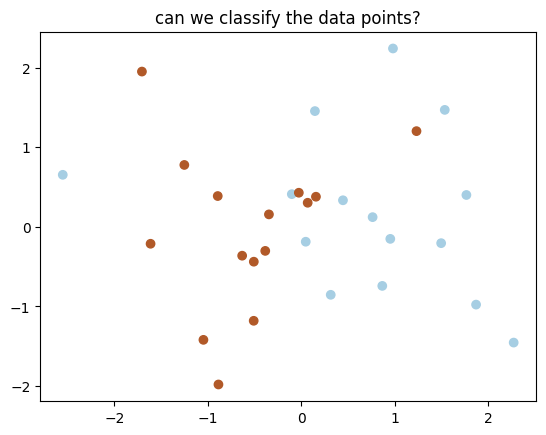

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
X=np.random.randn(30,2)
y=np.repeat([0,1],15)

plt.title("can we classify the data points?")
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.Paired)
plt.show()

Text(0, 0.5, 'X2')

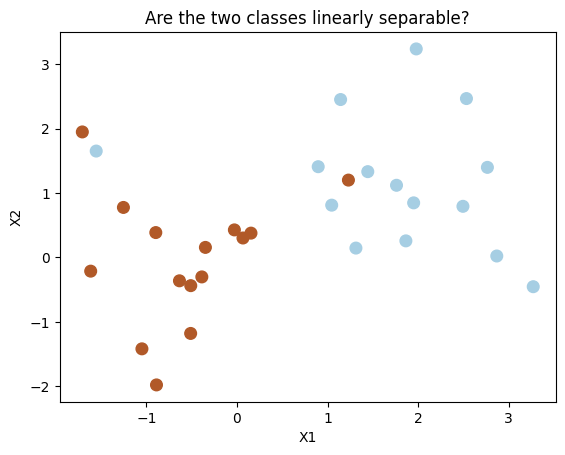

In [ ]:
X[y == 0] = X[y == 0] +1
plt.title('Are the two classes linearly separable?', color='k')
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline
plt.style.use('seaborn-white')

<ipython-input-10-27065a2be064>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [ ]:
model=SVC(kernel='linear')
model.fit(X,y)

SVC(kernel='linear')

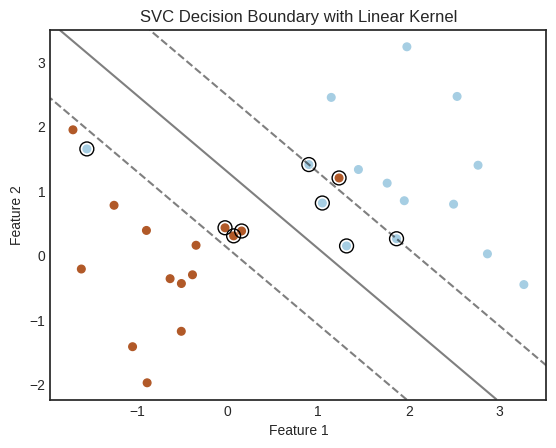

In [ ]:
# Plotting the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30)

# Create a grid to evaluate the model
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))

# Evaluate model the grid
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Plot support vectors
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVC Decision Boundary with Linear Kernel')
plt.show()


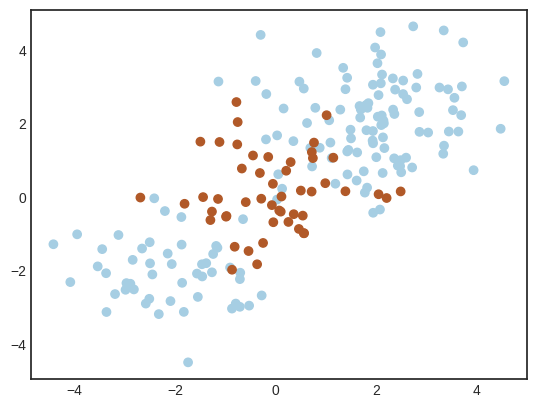

In [ ]:
np.random.seed(8)

X=np.random.randn(200,2)
X[:100]=X[:100]+2
X[101:150]=X[101:150]-2
y=np.concatenate([np.repeat(-1,150),np.repeat(1,50)])
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
plt.scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired)
plt.show()


# Train

Train Epoch: 1 [0/202599 (0%)]	Loss: 1324.983887
Train Epoch: 1 [6400/202599 (3%)]	Loss: 688.418823
Train Epoch: 1 [12800/202599 (6%)]	Loss: 435.604370
Train Epoch: 1 [19200/202599 (9%)]	Loss: 385.712952
Train Epoch: 1 [25600/202599 (13%)]	Loss: 348.446198
Train Epoch: 1 [32000/202599 (16%)]	Loss: 310.603455
Train Epoch: 1 [38400/202599 (19%)]	Loss: 309.837402
Train Epoch: 1 [44800/202599 (22%)]	Loss: 297.586700
Train Epoch: 1 [51200/202599 (25%)]	Loss: 288.220978
Train Epoch: 1 [57600/202599 (28%)]	Loss: 273.656433
Train Epoch: 1 [64000/202599 (32%)]	Loss: 264.642090
Train Epoch: 1 [70400/202599 (35%)]	Loss: 269.092529
Train Epoch: 1 [76800/202599 (38%)]	Loss: 265.559113
Train Epoch: 1 [83200/202599 (41%)]	Loss: 253.727585
Train Epoch: 1 [89600/202599 (44%)]	Loss: 247.120926
Train Epoch: 1 [96000/202599 (47%)]	Loss: 269.595001
Train Epoch: 1 [102400/202599 (51%)]	Loss: 235.951965
Train Epoch: 1 [108800/202599 (54%)]	Loss: 248.284332
Train Epoch: 1 [115200/202599 (57%)]	Loss: 242.61520

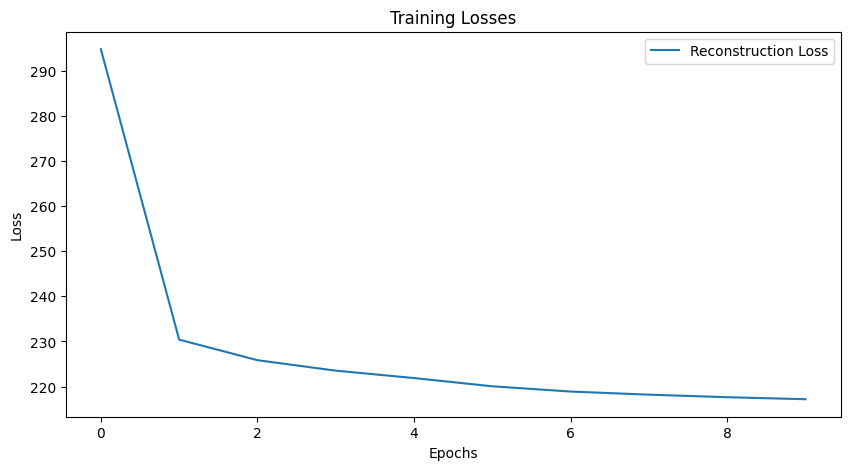

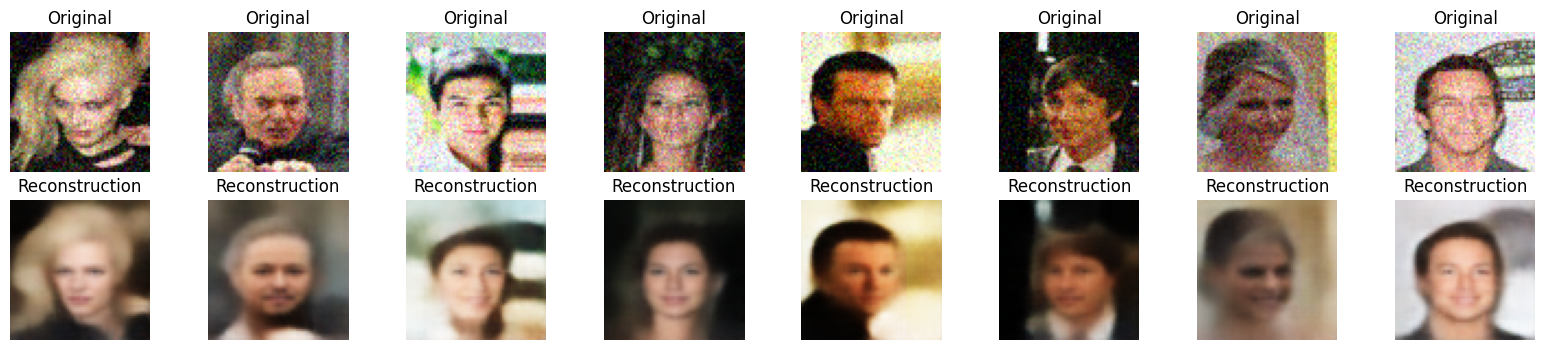

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
# from models import VAE
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
# from models import VAE
from sklearn.model_selection import train_test_split




            #CIFAR10  train=True instead of split='train'

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# the hyperparameters
batch_size = 64
epochs =10
latent_dim = 64
learning_rate = 1e-3
lambda_ = 1
#  adding Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Download the CelebA dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(), AddGaussianNoise(0.0, 0.1),        # Convert images to PyTorch tensors
])
#celeba_dataset=datasets.CelebA(root='./celeba/images', split='train', download=False, transform=transform)
# celeba_dataset = datasets.CelebA(root='/content/celeba', split='train', download=False, transform=transform)
celeba_dataset = datasets.ImageFolder('/content/celeba', transform=transform)

# Create a DataLoader for the CelebA dataset
train_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)


# Initialize VAE model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# List to track Loss
recon_losses = []
kl_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # data = data + torch.randn()
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(data)
        recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + (kl_loss * lambda_ / batch_size)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_recon_loss = train_loss / len(train_loader.dataset)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(kl_loss.item() / len(train_loader.dataset))
    print(f'====> Epoch: {epoch} Average loss: {avg_recon_loss:.4f}')

# Plotting the losses after training
def visualize_training_loss():
    plt.figure(figsize=(10,5))
    plt.title("Training Losses")
    plt.plot(recon_losses, label="Reconstruction Loss")
    # plt.plot(kl_losses, label="KL Divergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(train_loader))
        data = data.to(device)
        reconstruction, _, _ = model(data)
        data = data.cpu()
        reconstruction = reconstruction.cpu()

        # Display original and reconstructed images
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(20, 4))
        for i in range(num_images):
            axs[0, i].imshow(np.transpose(data[i].numpy(), (1, 2, 0)))
            axs[0, i].set_title('Original')
            axs[1, i].imshow(np.transpose(reconstruction[i].numpy(), (1, 2, 0)))
            axs[1, i].set_title('Reconstruction')
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

for epoch in range(1, epochs + 1):
    train(epoch)

torch.save(model.state_dict(), 'vae_model.pth')


visualize_training_loss()
visualize_reconstructions()